# Lens Trajectories

- z is the beam axis
- x and y are off axis

There are 3 apartures, one in front of the lens, one in front of the field plates and another in front of the detection region, plus a collimator inside the beamsource.

Source is at 6.35 mm. Source is in diameter of the aparture away from the aparture.

- collimator : conical shape, starts @ z = .325 inches, .232 inches diameter, @ z = 1.325 inch, 1 inch diameter
- in front of lens : circular with diameter of lens, 1 mm in front -> not feasible in real life
- in front of field plates : 18 mm x, 100 mm y @ z = 1.7 m  
- in front of det. region : 10 mm x, 30 mm y @ z = 5.09 m

The trajectories and velocities are stored in matlab file format, which is easily opened with scipy.io.loadmat.

In [743]:
from scipy.io import loadmat
positions = loadmat('positions_545.mat')
velocities = loadmat('velocities_545.mat')

In [744]:
pos = positions['x_alive'][0]
vel = velocities['v_alive'][0]

In [745]:
nrPoints = len(pos[0][0])
nrTrajectories = len(pos)

xT = np.empty([nrPoints, nrTrajectories])
yT = np.empty([nrPoints, nrTrajectories])
zT = np.empty([nrPoints, nrTrajectories])
for idP in range(nrTrajectories):
    xT[:,idP] = pos[idP][0]
    yT[:,idP] = pos[idP][1]
    zT[:,idP] = pos[idP][2]
    
xVelocity = np.empty([nrPoints, nrTrajectories])
yVelocity = np.empty([nrPoints, nrTrajectories])
zVelocity = np.empty([nrPoints, nrTrajectories])
for idP in range(nrTrajectories):
    xVelocity[:,idP] = vel[idP][0]
    yVelocity[:,idP] = vel[idP][1]
    zVelocity[:,idP] = vel[idP][2]

The Matlab code (Oskari) used to generate the trajectories saves the same coordinate twice for two coordinate sets.

In [747]:
mask = np.invert(np.diff(zT[:,0]) == 0)
mask = np.append(np.array([True]), mask)

In [749]:
nrPointsFiltered = nrPoints - np.invert(mask).sum()
xFiltered = np.empty([nrPointsFiltered, nrTrajectories])
yFiltered = np.empty([nrPointsFiltered, nrTrajectories])
zFiltered = np.empty([nrPointsFiltered, nrTrajectories])
xVelocityFiltered = np.empty([nrPointsFiltered, nrTrajectories])
yVelocityFiltered = np.empty([nrPointsFiltered, nrTrajectories])
zVelocityFiltered = np.empty([nrPointsFiltered, nrTrajectories])
for idP in range(nrTrajectories):
    xFiltered[:,idP] = xT[:,idP][mask]
    yFiltered[:,idP] = yT[:,idP][mask]
    zFiltered[:,idP] = zT[:,idP][mask]
    xVelocityFiltered = xVelocity[:,idP][mask]
    yVelocityFiltered = yVelocity[:,idP][mask]
    zVelocityFiltered = zVelocity[:,idP][mask]

Lens starts at $z=0.8052~\text{m}$ and has $60~\text{cm}$ length. Rod diameter is $1.75~\text{inch}$ and the diameter of the lens bore is also $1.75~\text{inch}$.

Text(0,0.5,'r [m]')

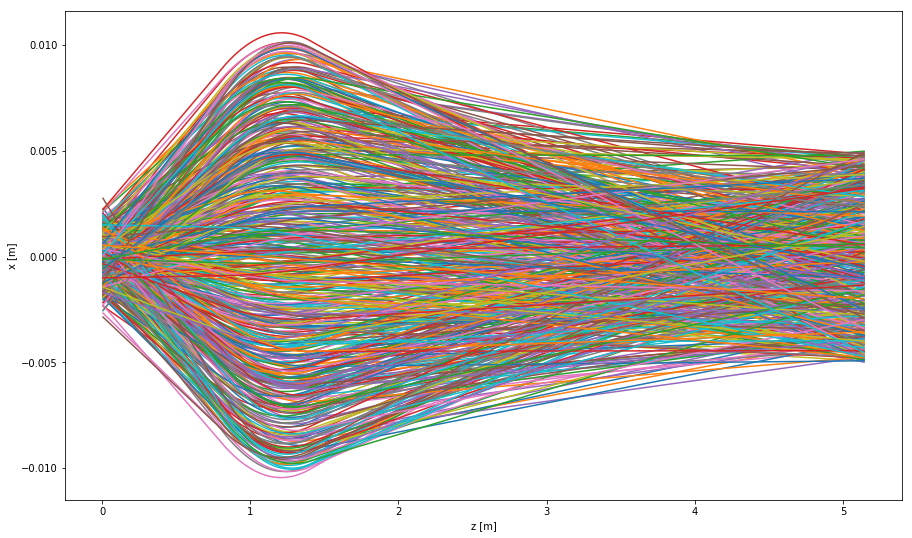

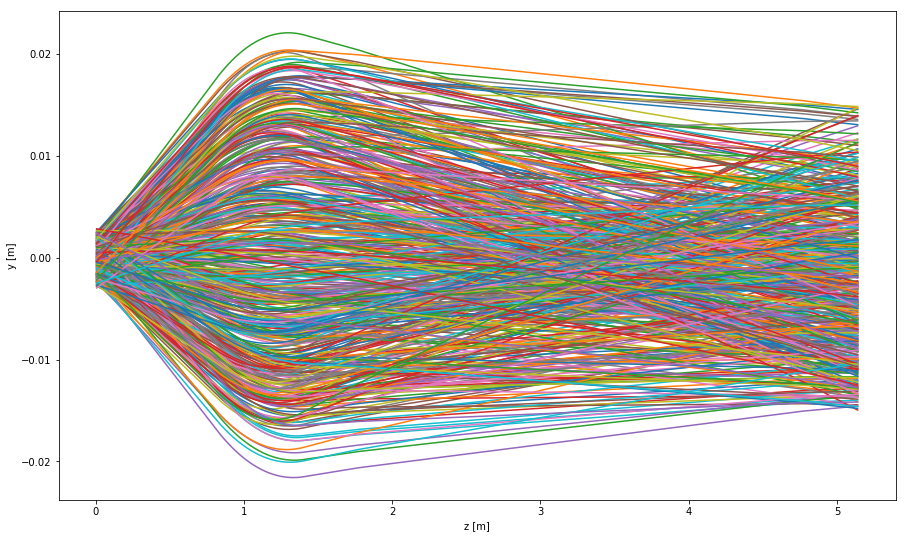

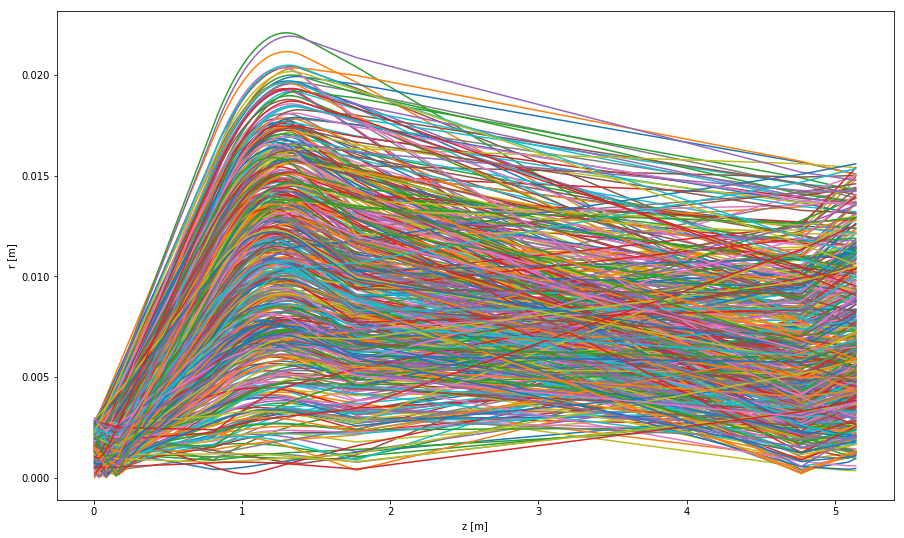

In [750]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zT,xT);
ax.set_xlabel('z [m]')
ax.set_ylabel('x [m]')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zT,yT);
ax.set_xlabel('z [m]')
ax.set_ylabel('y [m]')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zT,np.sqrt(xT**2+yT**2));
ax.set_xlabel('z [m]')
ax.set_ylabel('r [m]')

In [751]:
np.sqrt(xT**2+yT**2).max()

0.022080795297148195

Gravity is included in the simulation, and y is the axis on which gravity works.

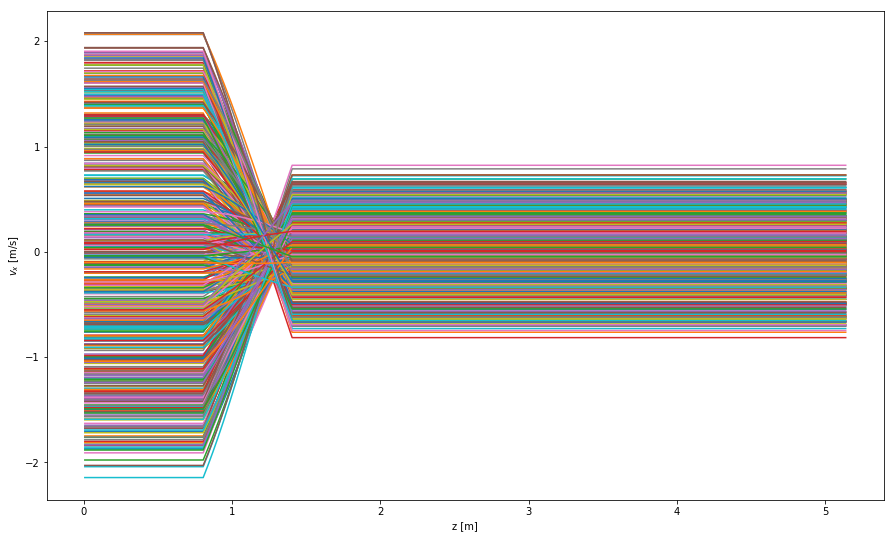

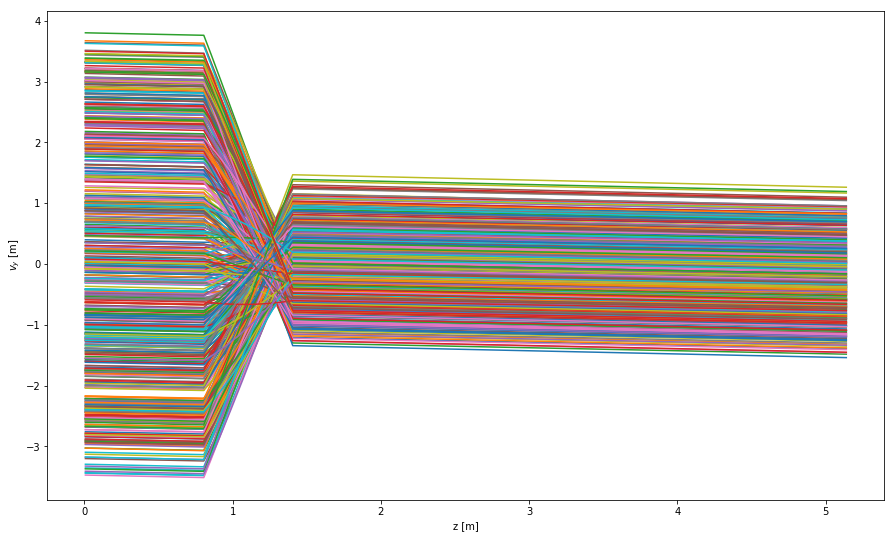

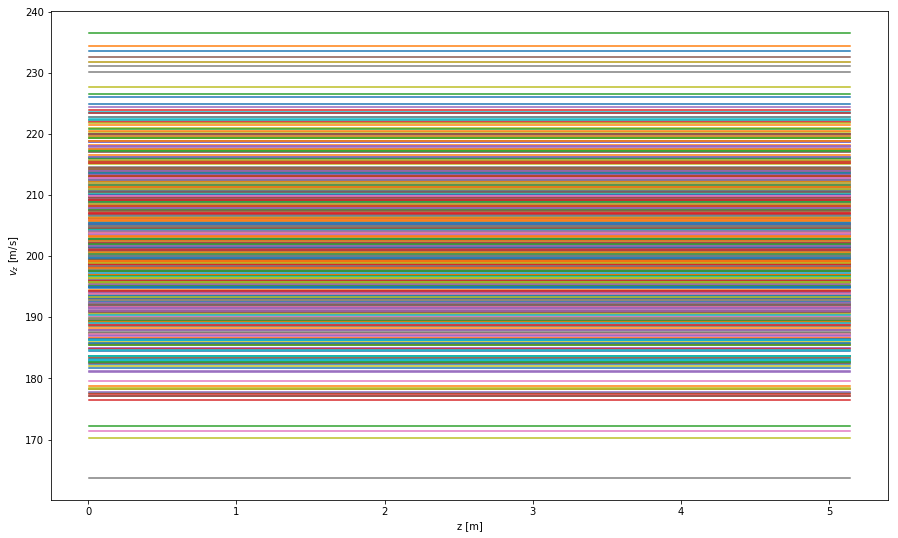

In [752]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zT,xVelocity);
ax.set_xlabel('z [m]')
ax.set_ylabel(r'$v_x$ [m/s]')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zT,yVelocity);
ax.set_xlabel('z [m]')
ax.set_ylabel(r'$v_y$ [m]')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zT,zVelocity);
ax.set_xlabel('z [m]')
ax.set_ylabel(r'$v_z$ [m/s]');

gravity works on the y axis

# Interpolation of Trajectories for Differential Equations

The propagation of states also requires timesteps inbetween the ones recieved from Oskari's simulation. Easiest way to accomplish this is with an interpolating function. Linear for x and z, quadratic for y since gravity works on that axis.

The lens starts at $z=0.8052~\text{m}$, but the electric field simulations have the lens center at $z=0~\text{m}$. Want to start the trajectories at $z=-0.45~\text{m}$, which is the center of the parallel plates, which is roughly $0.15~\text{m}$ in front of the lens. Need to rescale the interpolation function to accomplish this.

In [766]:
vTot = np.sqrt(xVelocity**2+yVelocity**2+zVelocity**2)
distance = np.sqrt(np.diff(xT, axis = 0)**2+np.diff(yT, axis = 0)**2+np.diff(zT, axis = 0)**2)

In [780]:
t = np.zeros(vTot.shape)
t[1:] = np.cumsum(distance/vTot[:-1], axis = 0)

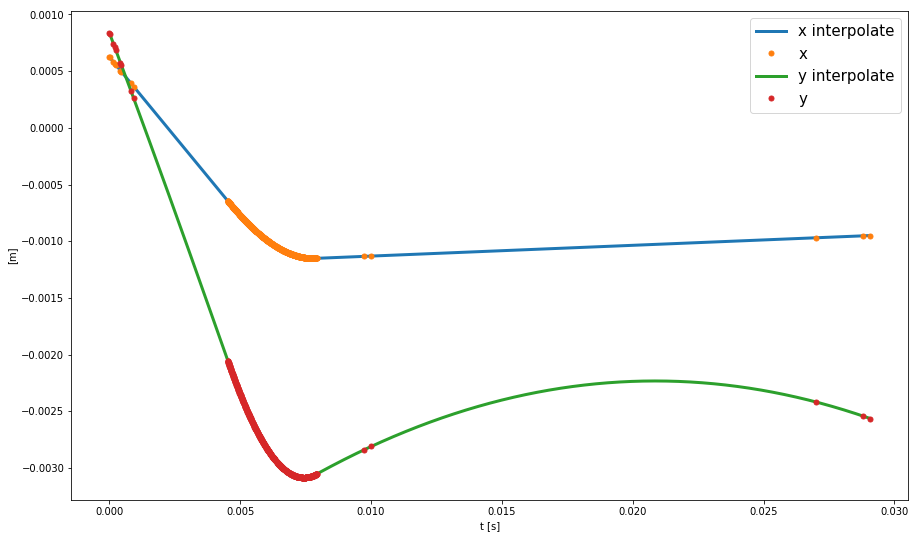

In [957]:
idInt = 23
from scipy.interpolate import interp1d
intTrajX = interp1d(t[:,idInt], xT[:,idInt], kind = 'linear')
intTrajY = interp1d(t[:,idInt], yT[:,idInt], kind = 'quadratic')
intTrajZ = interp1d(t[:,idInt], zT[:,idInt], kind = 'linear')

tInt = np.arange(t[:,idInt].min(), t[:,idInt].max(), 1e-5)
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(tInt, intTrajX(tInt), lw = 3, label = 'x interpolate')
ax.plot(t[:,idInt], xT[:,idInt], '.', ms = 10, label = 'x')
ax.plot(tInt, intTrajY(tInt), lw = 3, label = 'y interpolate')
ax.plot(t[:,idInt], yT[:,idInt], '.', ms = 10, label = 'y')
ax.set_xlabel('t [s]')
ax.set_ylabel('[m]')
ax.legend(fontsize = 15);

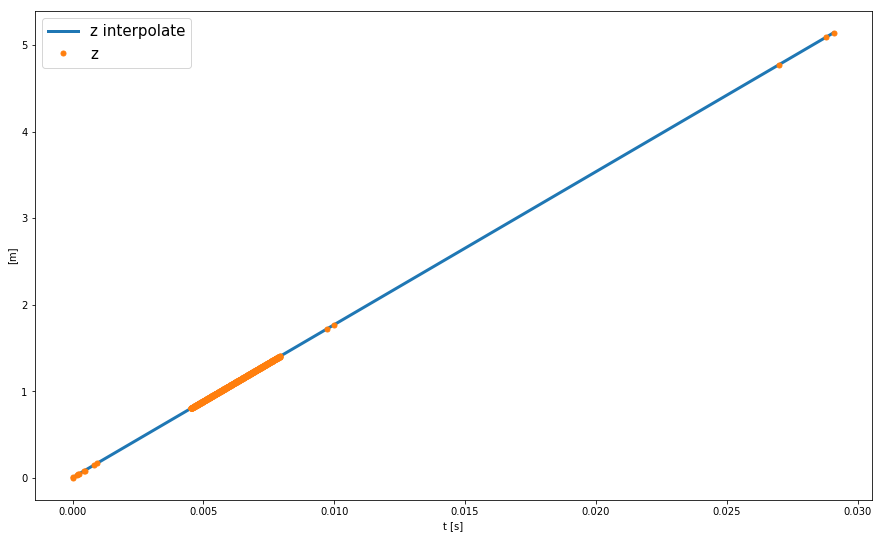

In [945]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(tInt, intTrajZ(tInt), lw = 3, label = 'z interpolate')
ax.plot(t[:,idInt], zT[:,idInt], '.', ms = 10, label = 'z')
ax.set_xlabel('t [s]')
ax.set_ylabel('[m]')
ax.legend(fontsize = 15);

In [951]:
from scipy.optimize import brentq
rootfun = lambda t: intTrajZ(t) - (0.8052-0.15)
tstart = brentq(rootfun, 0.0025, 0.0045)
rootfun = lambda t: intTrajZ(t) - (0.8052+0.6+0.15)
tstop = brentq(rootfun, 0.005, 0.02)
print(tstart, tstop)
print(tstop-tstart)

0.0036753107473716812 0.008773220788122484
0.005097910040750803


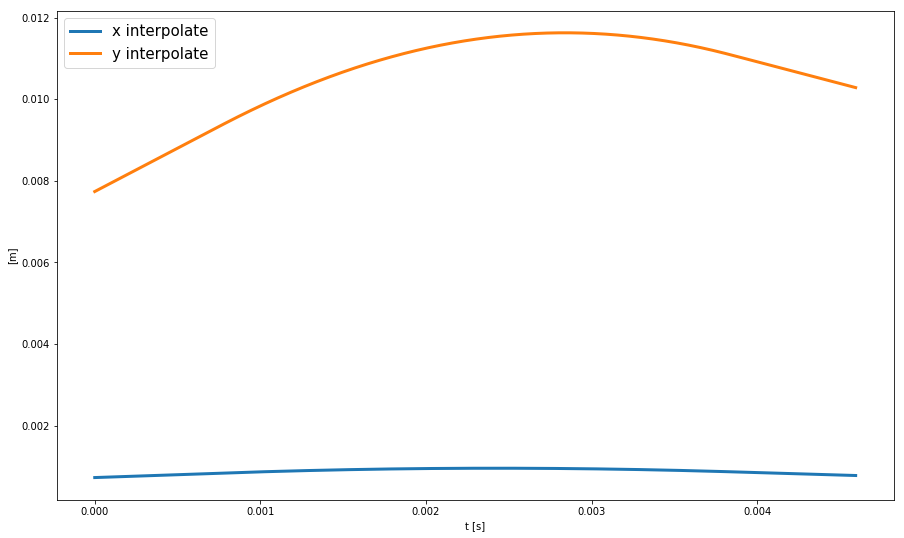

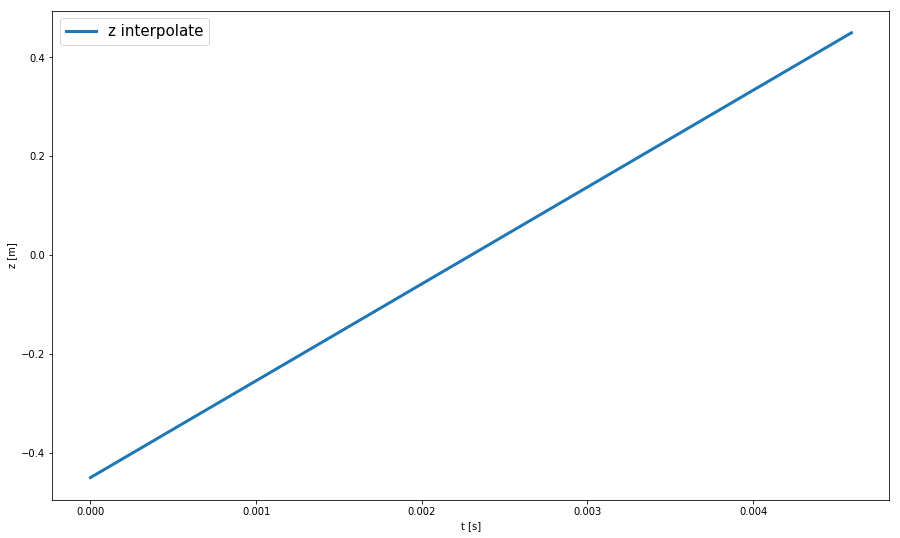

In [905]:
intTrajX_rescale = lambda t: intTrajX(t+tstart)
intTrajY_rescale = lambda t: intTrajY(t+tstart)
intTrajZ_rescale = lambda t: intTrajZ(t+tstart)-(0.8052-0.15)-0.45
tInt = np.arange(0, tstop-tstart, 1e-6)

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(tInt, intTrajX_rescale(tInt), lw = 3, label = 'x interpolate')
ax.plot(tInt, intTrajY_rescale(tInt), lw = 3, label = 'y interpolate')
ax.set_xlabel('t [s]')
ax.set_ylabel('[m]')
ax.legend(fontsize = 15);

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(tInt, intTrajZ_rescale(tInt), lw = 3, label = 'z interpolate')
ax.set_xlabel('t [s]')
ax.set_ylabel('z [m]')
ax.legend(fontsize = 15);

In [971]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq

interpolateTrajectories = []
for idInt in range(t.shape[1]):
    intTrajX = interp1d(t[:,idInt], xT[:,idInt], kind = 'linear')
    intTrajY = interp1d(t[:,idInt], yT[:,idInt], kind = 'quadratic')
    intTrajZ = interp1d(t[:,idInt], zT[:,idInt], kind = 'linear')

    rootfun = lambda t: intTrajZ(t) - (0.8052-0.15)
    tstart = brentq(rootfun, 0.0025, 0.0045)
    rootfun = lambda t: intTrajZ(t) - (0.8052+0.6+0.15)
    tstop = brentq(rootfun, 0.005, 0.01)

    intTrajX_rescale = lambda t: intTrajX(t+tstart)
    intTrajY_rescale = lambda t: intTrajY(t+tstart)
    intTrajZ_rescale = lambda t: intTrajZ(t+tstart)-(0.8052-0.15)-0.45
    interpolateTrajectories.append((intTrajX_rescale,intTrajY_rescale,intTrajZ_rescale,tstop-tstart))

# Quadrupole Potential

In [866]:
import numpy as np

rfp = open('potentialQuadrupole.fld', 'r')
tmp = rfp.read()
tmp = tmp.split('\n')[2:-1]
tmp = [[float(tis) for tis in ti.split()] for ti in tmp]

x = np.array([row[0] for row in tmp])
y = np.array([row[1] for row in tmp])
z = np.array([row[2] for row in tmp])
V = np.array([row[3] for row in tmp])

In [867]:
mask = (np.sqrt(x**2+y**2) > 0.022)
V[mask] = np.nan

In [868]:
def create_grid_potential(x,y,z,data):
    x_vals, x_idx = np.unique(x, return_inverse=True)
    y_vals, y_idx = np.unique(y, return_inverse=True)
    z_vals, z_idx = np.unique(z, return_inverse=True)

    datax_grid = np.empty([max(x_vals.shape), max(y_vals.shape), max(z_vals.shape)])
    datax_grid.fill(np.nan)
    datax_grid[x_idx,y_idx,z_idx] = data
    return (x_vals, y_vals, z_vals), datax_grid

In [869]:
from numpy.polynomial import polynomial
import numpy as np

def polyfit3d(x, y, z, f, deg):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = polynomial.polyvander3d(x, y, z, deg)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

In [870]:
(x_vals, y_vals, z_vals), pot_vals = create_grid_potential(x,y,z,V)

In [871]:
c = polyfit3d(x[np.invert(mask)],y[np.invert(mask)],z[np.invert(mask)],V[np.invert(mask)], deg = [10,10,10])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


-0.1


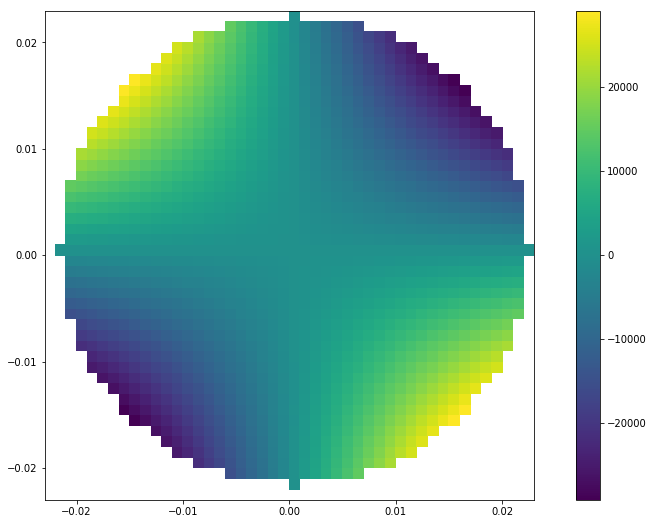

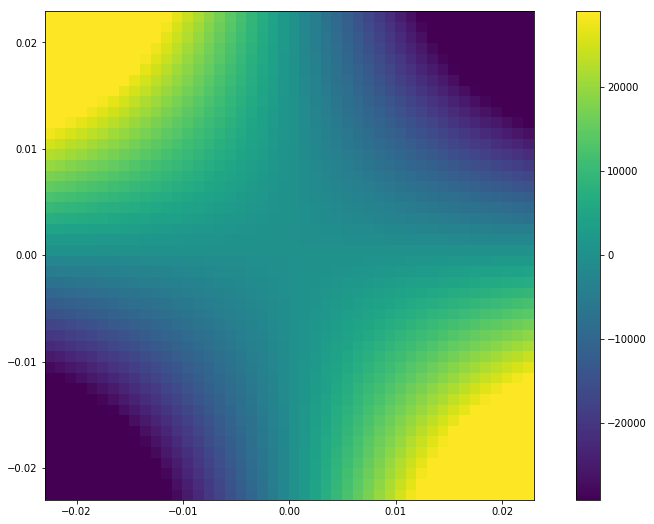

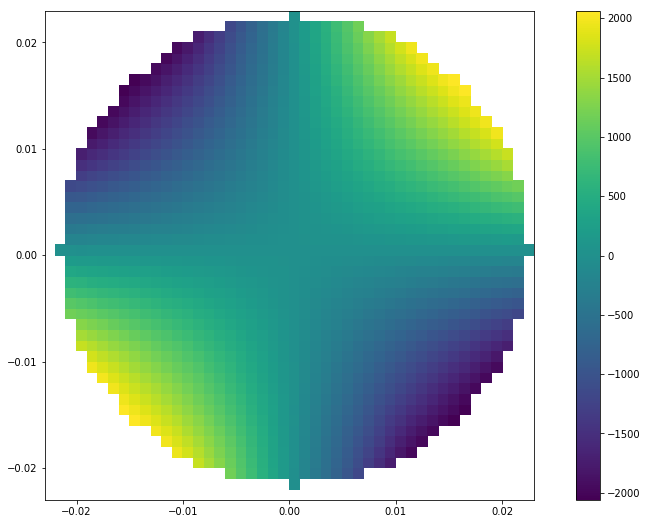

In [872]:
import matplotlib.pyplot as plt
%matplotlib inline

idz = 0
print(z_vals[idz])

fig, ax = plt.subplots(figsize = (15,9))
cax = ax.pcolormesh(X,Y, pot_vals[:,:,idz])
cbar = fig.colorbar(cax)
ax.set_aspect(y.ptp()/x.ptp())


v = cax.get_clim()
X,Y = np.meshgrid(x_vals, y_vals)
fig, ax = plt.subplots(figsize = (15,9))
cax = ax.pcolormesh(X,Y, polynomial.polyval3d(X, Y, z_vals[idz], c),
                vmin = v[0], vmax = v[1])
cbar = fig.colorbar(cax)
ax.set_aspect(y.ptp()/x.ptp())

X,Y = np.meshgrid(x_vals, y_vals)
fig, ax = plt.subplots(figsize = (15,9))
cax = ax.pcolormesh(X, Y, polynomial.polyval3d(X, Y, z_vals[idz], c)-pot_vals[:,:,idz])
cbar = fig.colorbar(cax)
ax.set_aspect(y.ptp()/x.ptp())


In [873]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

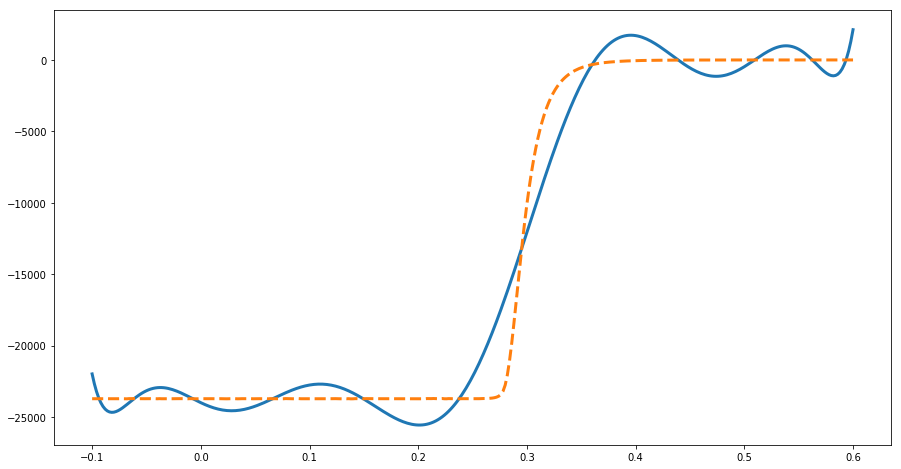

In [874]:
maskgrid = np.ones(len(z_vals), dtype = bool)
idx = find_nearest(x_vals, np.sqrt(0.0199**2/2))
idy = find_nearest(y_vals, np.sqrt(0.0199**2/2))
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(z_vals[maskgrid], polynomial.polyval3d(x_vals[idx]*np.ones(len(z_vals[maskgrid])), 
                                               y_vals[idy]*np.ones(len(z_vals[maskgrid])), 
                                               z_vals[maskgrid], c), lw = 3)
ax.plot(z_vals, pot_vals[idx, idy, :].flatten(),'--', lw = 3)

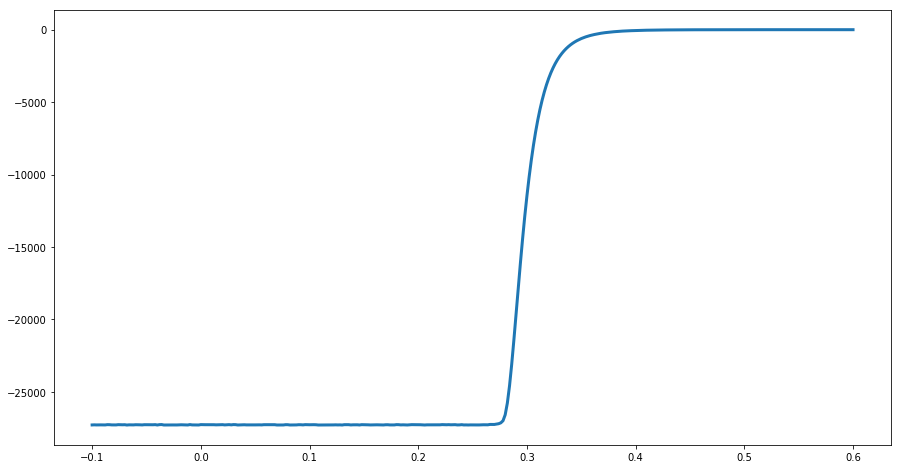

In [875]:
idx = find_nearest(x_vals, np.sqrt(0.0219**2/2))
idy = find_nearest(y_vals, np.sqrt(0.0219**2/2))
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(z_vals, pot_vals[idx, idy, :].flatten(), lw = 3)

In [876]:
maskz = z_vals > 0
f = np.abs(pot_vals[idx, idy, :].flatten())[maskz]
f -= f.min()
f /= f.max()

l = maskz.sum()
z_spliced = np.zeros(l*2)
ind_sort = np.argsort(-z_vals[maskz])
z_spliced[:l] = -z_vals[maskz][ind_sort]
z_spliced[-l:] = z_vals[maskz]
f_spliced = np.zeros(l*2)
f_spliced[:l] = f[ind_sort]
f_spliced[-l:] = f

from scipy.interpolate import interp1d, UnivariateSpline
intfun = UnivariateSpline(z_spliced, f_spliced, s = 0)

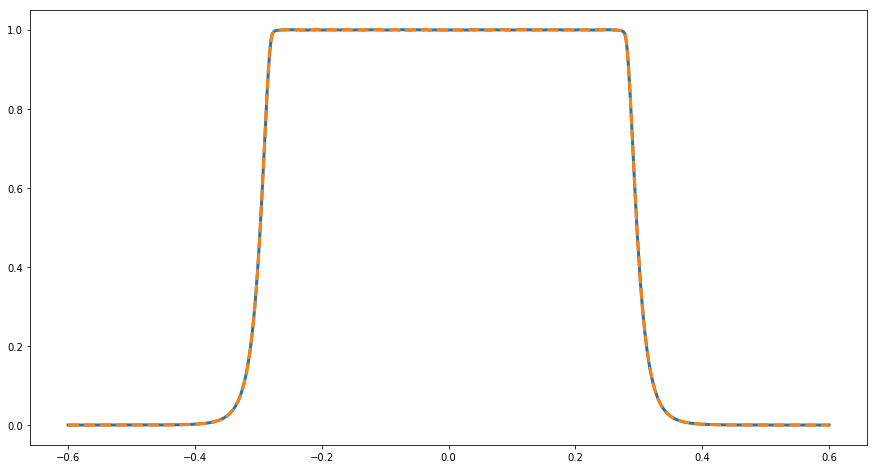

In [877]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(z_spliced, f_spliced, lw = 3)
ax.plot(z_spliced, intfun(z_spliced), '--', lw = 3)

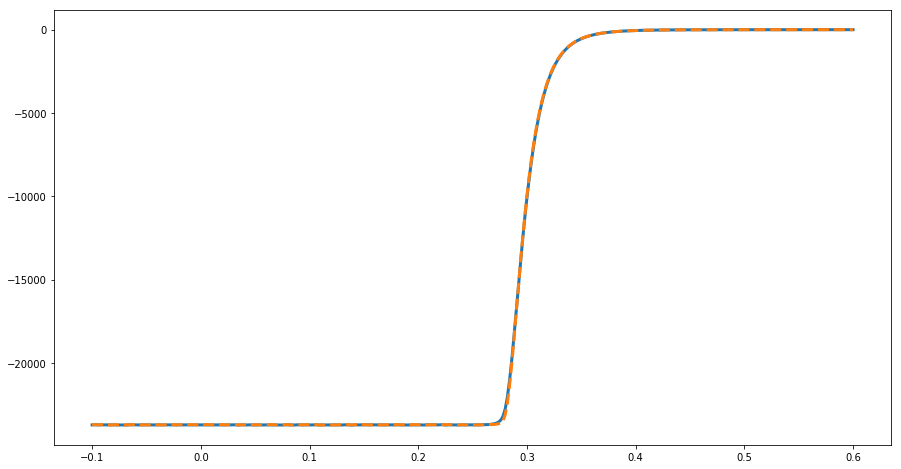

In [878]:
fmaskgrid = np.ones(len(z_vals), dtype = bool)
idx = find_nearest(x_vals, np.sqrt(0.0199**2/2))
idy = find_nearest(y_vals, np.sqrt(0.0199**2/2))
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(z_vals, pot_vals[idx, idy, :].flatten(), lw = 3)
ax.plot(z_vals, intfun(z_vals)*pot_vals[idx, idy, :].flatten().min(), '--', lw = 3)

In [879]:
def polyfit2d(x, y, f, deg):
    from numpy.polynomial import polynomial
    import numpy as np
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = polynomial.polyvander2d(x, y, deg)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

In [880]:
maskz = z[np.invert(mask)] == 0
c = polyfit2d(x[np.invert(mask)][maskz], y[np.invert(mask)][maskz], V[np.invert(mask)][maskz], [3,3])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


In [881]:
def plot_slice(x_vals,y_vals,z_vals,pot_vals, c, idz):
    print(z_vals[idz])
    X,Y = np.meshgrid(x_vals, y_vals)
    
    fig, ax = plt.subplots(figsize = (15,9))
    cax = ax.pcolormesh(X,Y, pot_vals[:,:,idz].T)
    cbar = fig.colorbar(cax)
    ax.set_aspect(y.ptp()/x.ptp())
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_title('Ansys')
    
    
    v = cax.get_clim()
    X,Y = np.meshgrid(x_vals, y_vals)
    fig, ax = plt.subplots(figsize = (15,9))
    cax = ax.pcolormesh(X,Y, polynomial.polyval2d(X, Y, c),
                    vmin = v[0], vmax = v[1])
    cbar = fig.colorbar(cax)
    ax.set_aspect(y.ptp()/x.ptp())
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_title('polynomial')
    

    fig, ax = plt.subplots(figsize = (15,9))
    cax = ax.pcolormesh(X,Y, pot_vals[:,:,idz].T-polynomial.polyval2d(X, Y, c))
    cbar = fig.colorbar(cax)
    ax.set_aspect(y.ptp()/x.ptp())
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_title('difference')

0.0


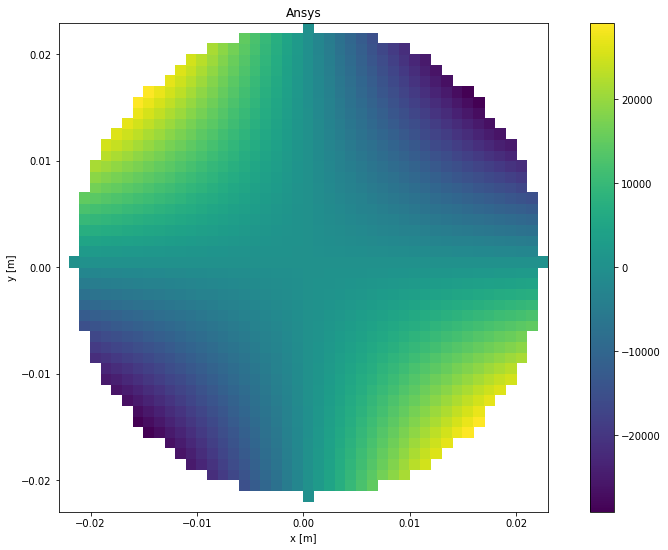

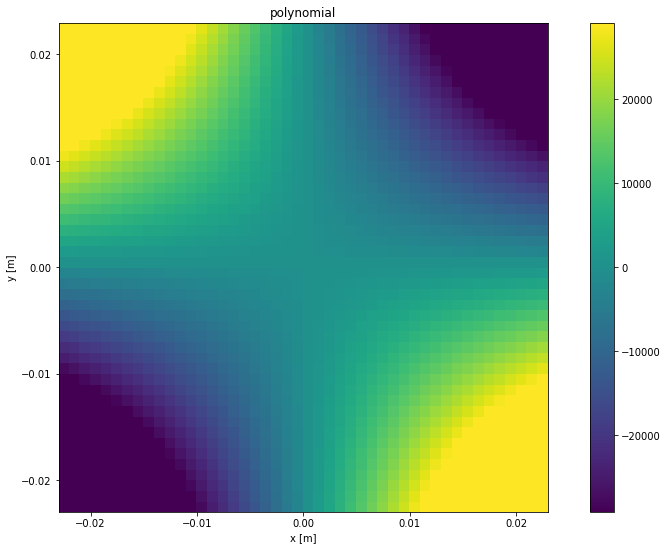

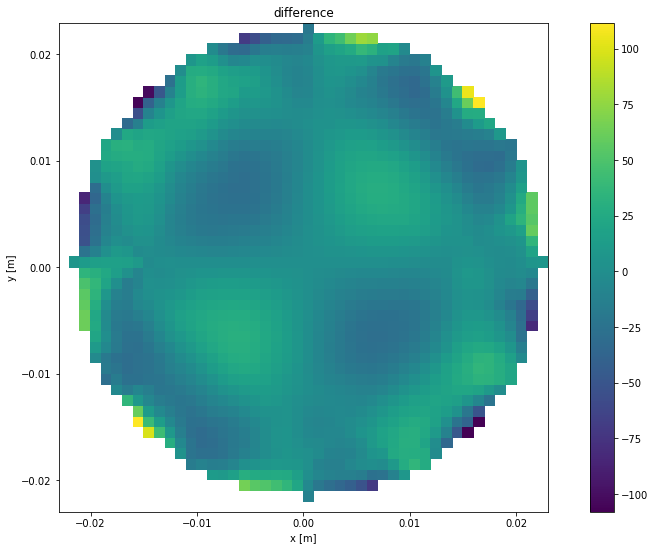

In [882]:
plot_slice(x_vals,y_vals,z_vals,pot_vals, c, 50)

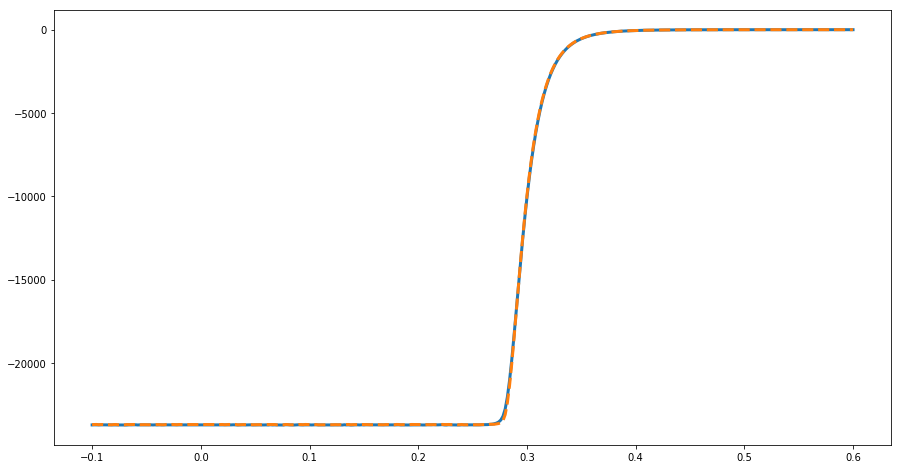

In [883]:
fmaskgrid = np.ones(len(z_vals), dtype = bool)
idx = find_nearest(x_vals, np.sqrt(0.0199**2/2))
idy = find_nearest(y_vals, np.sqrt(0.0199**2/2))
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(z_vals, pot_vals[idx, idy, :].flatten(), lw = 3)
ax.plot(z_vals, intfun(z_vals)*polynomial.polyval2d(x_vals[idx], y_vals[idy], c), '--', lw = 3)

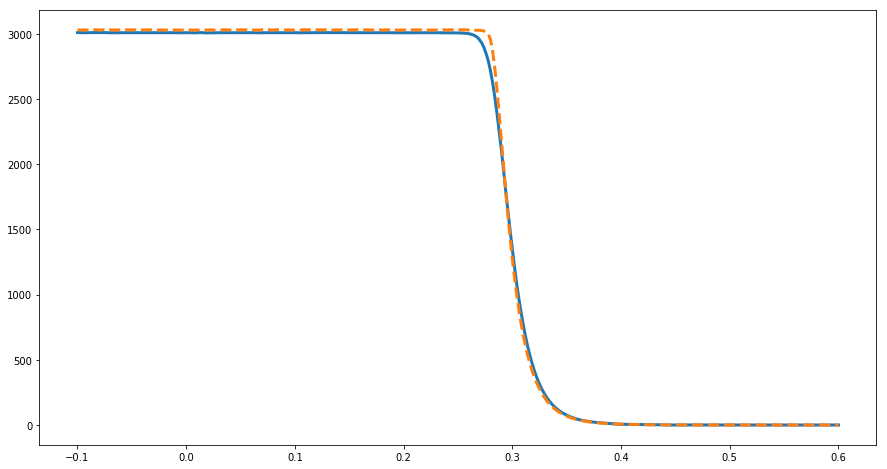

In [884]:
idx = find_nearest(x_vals, 0.005)
idy = find_nearest(y_vals, -0.005)
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(z_vals, pot_vals[idx, idy, :].flatten(), lw = 3)
ax.plot(z_vals, intfun(z_vals)*polynomial.polyval2d(x_vals[idx], y_vals[idy], c), '--', lw = 3)

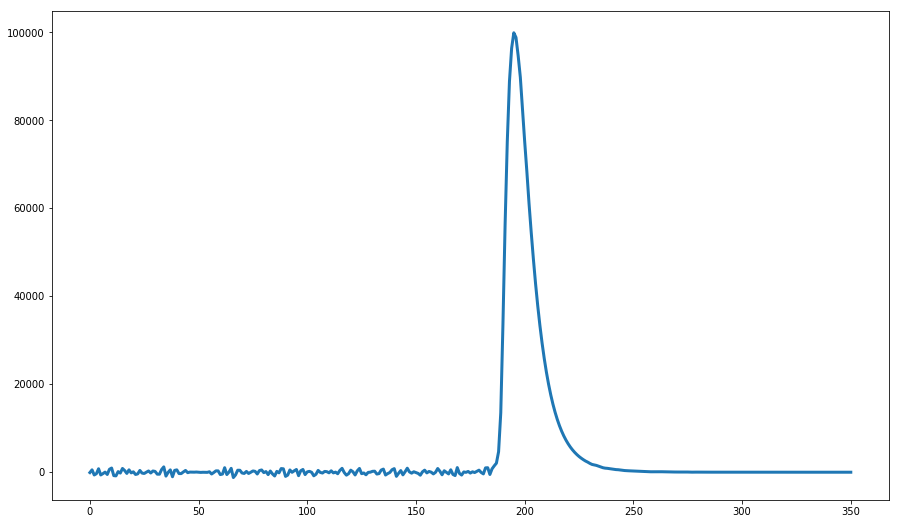

In [885]:
idx = find_nearest(x_vals, 0.005)
idy = find_nearest(y_vals, -0.005)
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(-polynomial.polyval2d(x_vals[idx], y_vals[idy], c)*intfun.derivative(1)(z_vals), lw = 3)

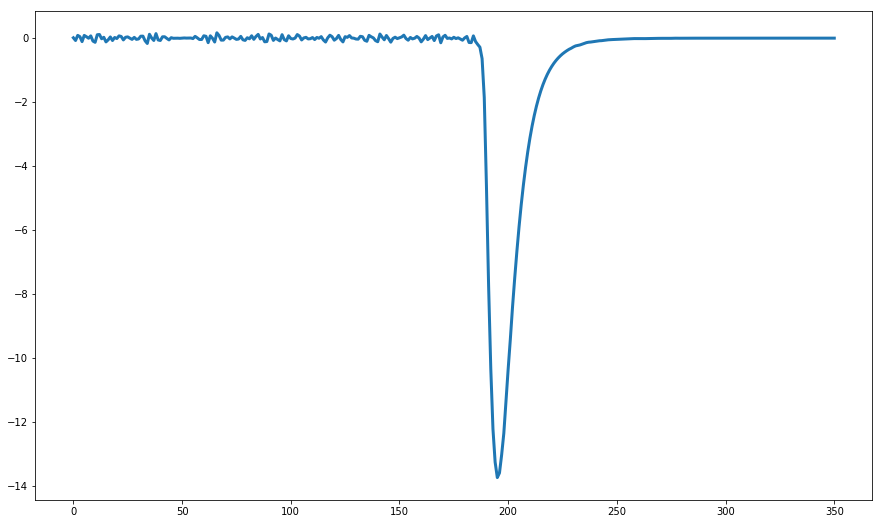

In [886]:
idx = find_nearest(x_vals, 0)
idy = find_nearest(y_vals, 0)
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(-polynomial.polyval2d(x_vals[idx], y_vals[idy], c)*intfun.derivative(1)(z_vals), lw = 3)

# Potential Plates

In [723]:
import numpy as np

rfp = open('potentialElectrodes.fld', 'r')
tmp = rfp.read()
tmp = tmp.split('\n')[2:-1]
tmp = [[float(tis) for tis in ti.split()] for ti in tmp]

xP = np.array([row[0] for row in tmp])
yP = np.array([row[1] for row in tmp])
zP = np.array([row[2] for row in tmp])
VP = np.array([row[3] for row in tmp])

In [724]:
mask = (np.sqrt(xP**2+yP**2) > 0.022)
VP[mask] = np.nan

(xP_vals, yP_vals, zP_vals), potP_vals = create_grid_potential(xP,yP,zP,VP)

In [725]:
maskz = np.abs(zP[np.invert(mask)] - 0.45) < 1e-4
cP = polyfit2d(xP[np.invert(mask)][maskz], yP[np.invert(mask)][maskz], VP[np.invert(mask)][maskz], [5,5])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


0.45000000000000007


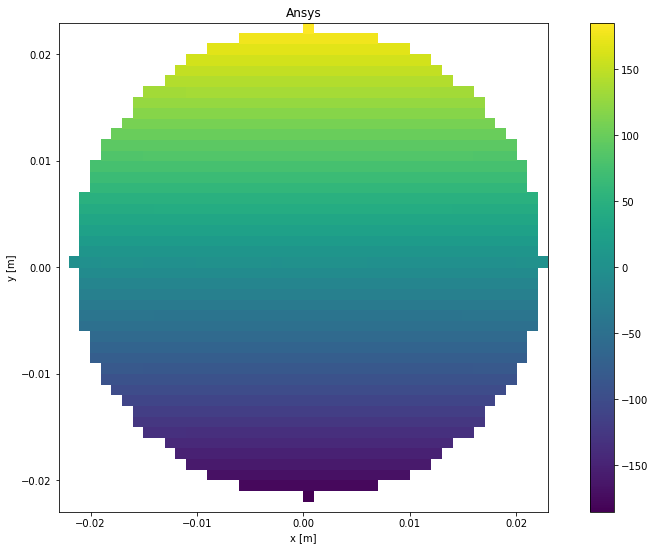

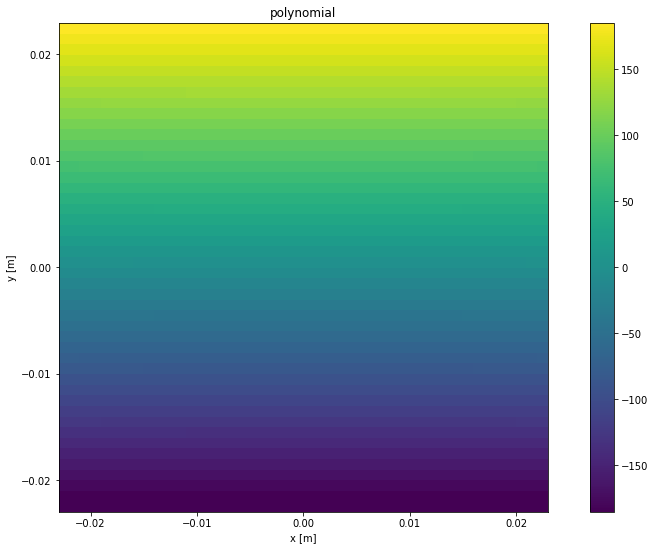

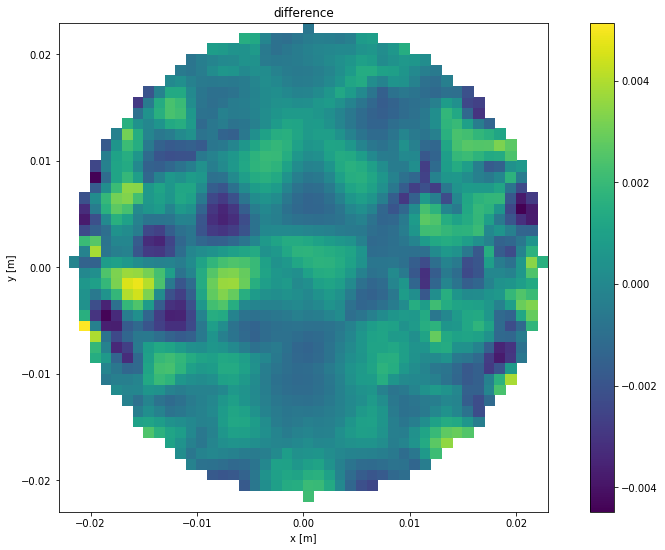

In [726]:
plot_slice(xP_vals, yP_vals, zP_vals, potP_vals, cP, 275)

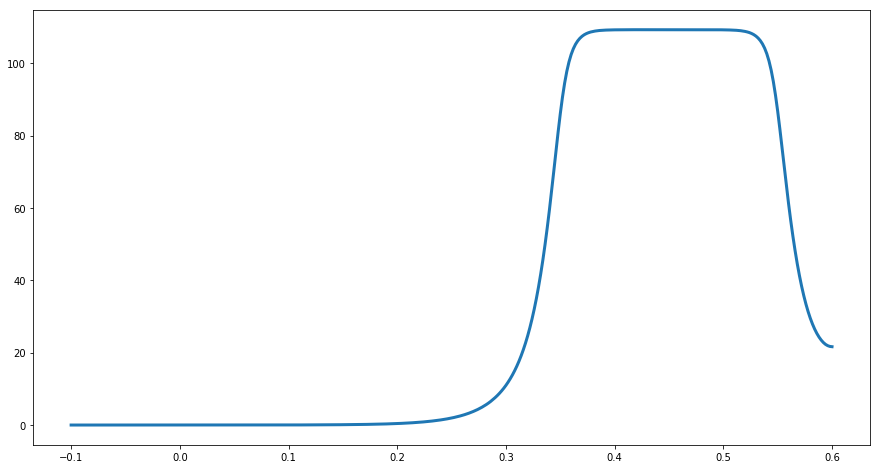

In [909]:
idx = find_nearest(xP_vals, np.sqrt(0.019**2/2))
idy = find_nearest(yP_vals, np.sqrt(0.019**2/2))
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(zP_vals, potP_vals[idx, idy, :].flatten(), lw = 3)

In [910]:
maskzP = zP_vals > 0
f = np.abs(potP_vals[idx, idy, :].flatten())[maskzP]
f -= f.min()
f /= f.max()

lP = maskzP.sum()
zP_spliced = np.zeros(lP*2+1)
ind_sort = np.argsort(-zP_vals[maskzP])
zP_spliced[:lP] = -zP_vals[maskzP][ind_sort]
zP_spliced[-lP:] = zP_vals[maskzP]
f_spliced = np.zeros(lP*2+1)
f_spliced[:lP] = f[ind_sort]
f_spliced[-lP:] = f

from scipy.interpolate import interp1d, UnivariateSpline
intfunP = UnivariateSpline(zP_spliced, f_spliced, s = 0)

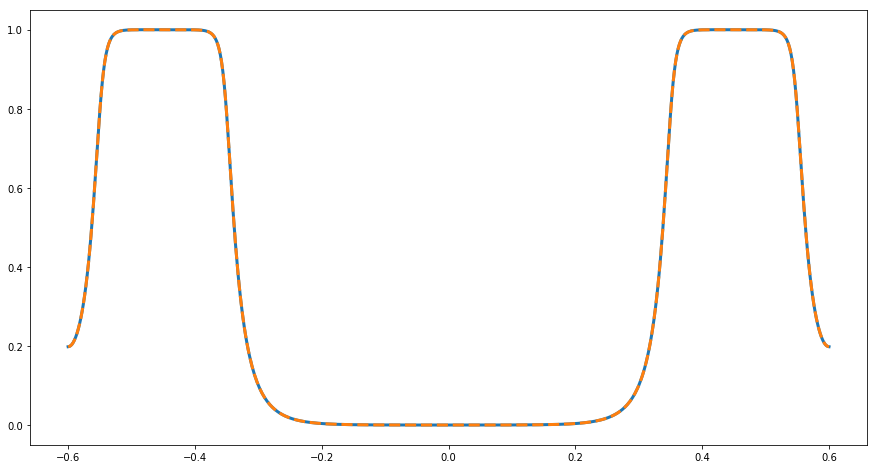

In [911]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(zP_spliced, f_spliced, lw = 3)
ax.plot(zP_spliced, intfunP(zP_spliced), '--', lw = 3)

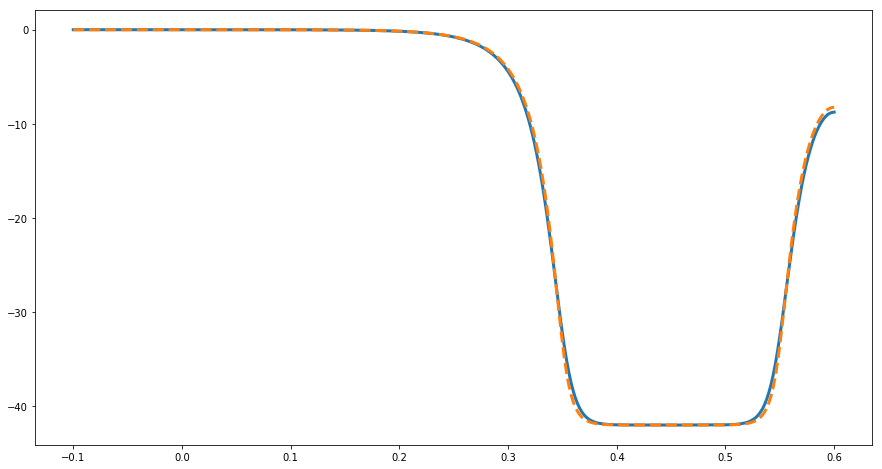

In [849]:
idx = find_nearest(xP_vals, -0.005)
idy = find_nearest(yP_vals, -0.005)
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(zP_vals, potP_vals[idx, idy, :].flatten(), lw = 3)
ax.plot(zP_vals, intfunP(zP_vals)*polynomial.polyval2d(xP_vals[idx], yP_vals[idy], cP), '--', lw = 3)

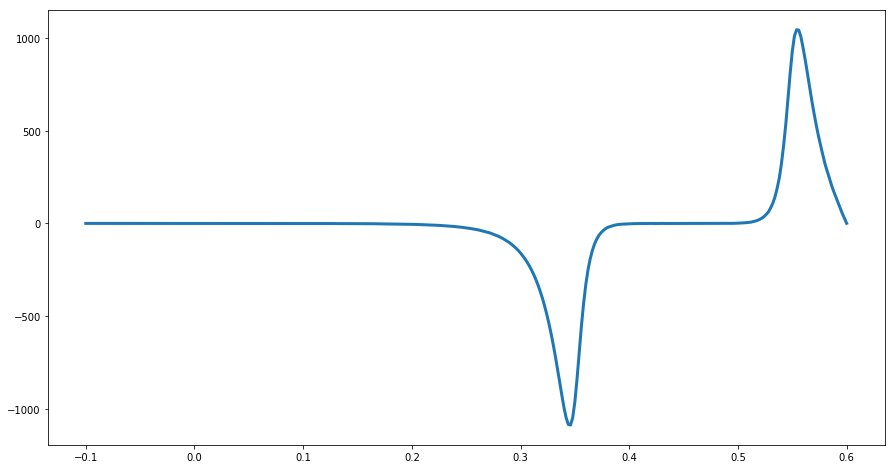

In [850]:
idx = find_nearest(xP_vals, -0.005)
idy = find_nearest(yP_vals, -0.005)
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(zP_vals, intfunP.derivative()(zP_vals)*polynomial.polyval2d(xP_vals[idx], yP_vals[idy], cP), lw = 3)

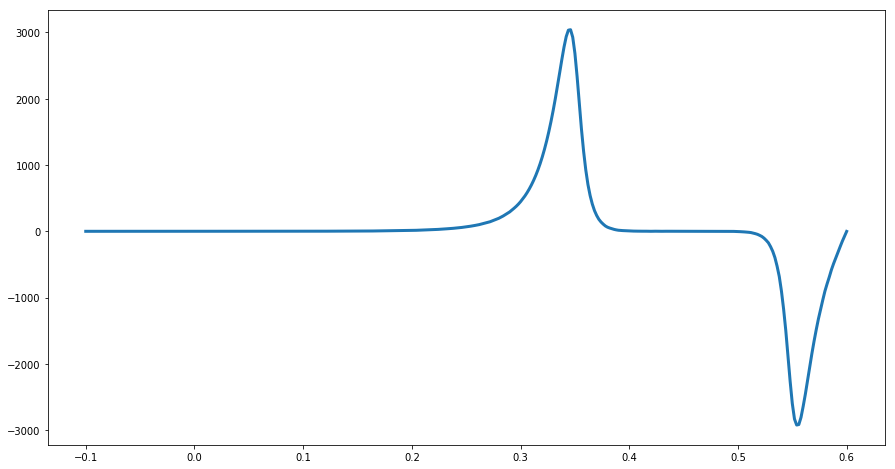

In [851]:
idx = find_nearest(xP_vals, np.sqrt(0.0199**2/2))
idy = find_nearest(yP_vals, np.sqrt(0.0199**2/2))
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(zP_vals, intfunP.derivative()(zP_vals)*polynomial.polyval2d(xP_vals[idx], yP_vals[idy], cP), lw = 3)

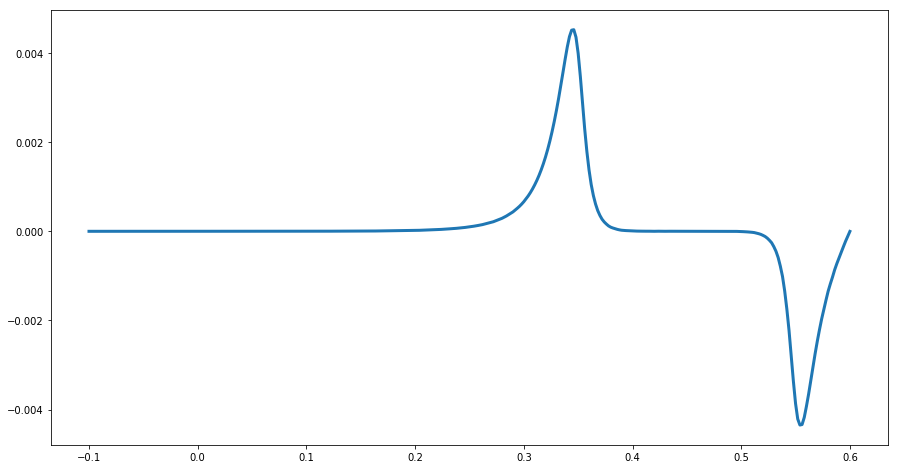

In [852]:
idx = find_nearest(xP_vals, 0)
idy = find_nearest(yP_vals, 0)
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(zP_vals, intfunP.derivative()(zP_vals)*polynomial.polyval2d(xP_vals[idx], yP_vals[idy], cP), lw = 3)

In [853]:
def plot_field(x_vals, y_vals, z_vals, c, intfun, idz, axis = 0):
    print(z_vals[idz])
    z = z_vals[idz]
    X,Y = np.meshgrid(x_vals, y_vals)

    cder = polynomial.polyder(c, axis = axis)
    fig, ax = plt.subplots(figsize = (15,9))
    if axis == 0 or axis == 1:
        cax = ax.pcolormesh(X,Y,-intfun(z)*polynomial.polyval2d(X, Y, cder))
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
    if axis == 0:
        ax.set_title('Ex')
    elif axis == 1: 
        ax.set_title('Ey')
    elif axis == 2:
        ax.set_title('Ez')
    cbar = fig.colorbar(cax)
    ax.set_aspect(y.ptp()/x.ptp())

0.45000000000000007
0.45000000000000007


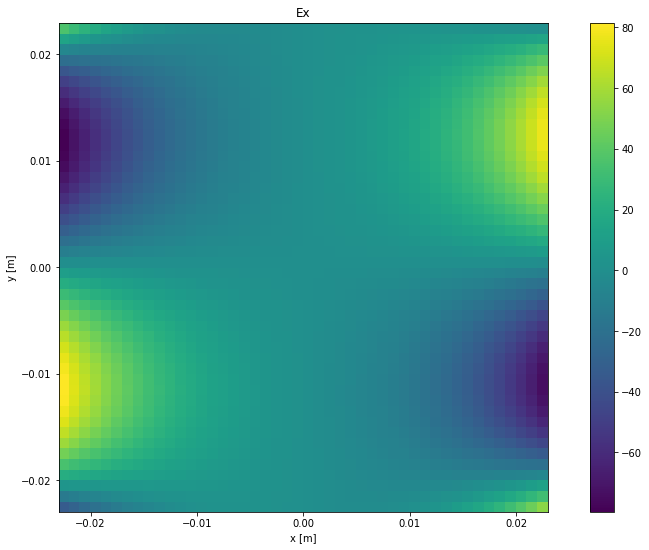

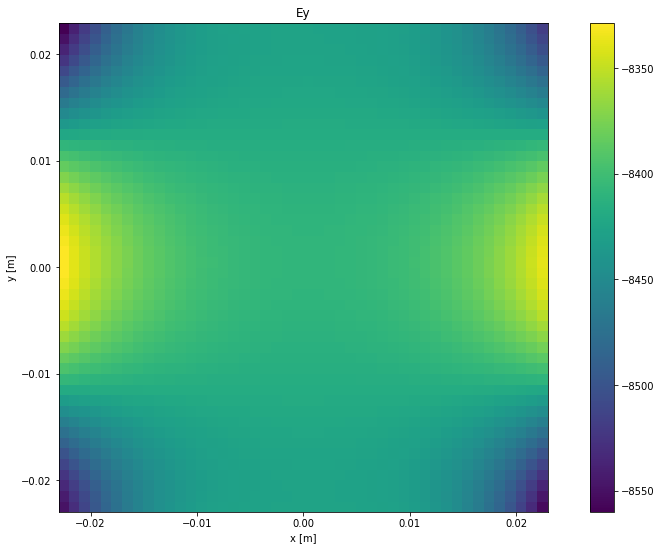

In [854]:
plot_field(xP_vals, yP_vals, zP_vals, cP, intfunP, 275, axis = 0)
plot_field(xP_vals, yP_vals, zP_vals, cP, intfunP, 275, axis = 1)

# Total Potential

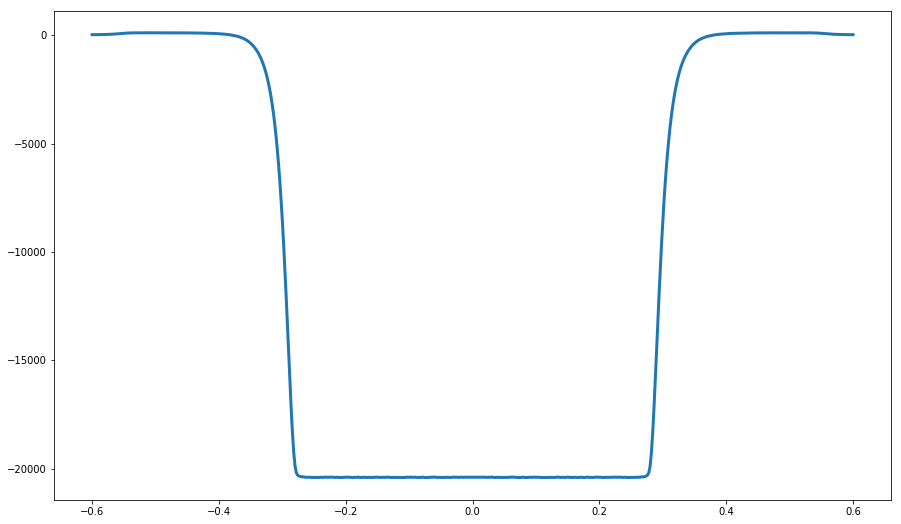

In [916]:
idx = find_nearest(xP_vals, np.sqrt(0.019**2/2))
idy = find_nearest(yP_vals, np.sqrt(0.019**2/2))
xi = xP_vals[idx]
yi = yP_vals[idx]

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, intfunP(zP_spliced)*polynomial.polyval2d(xi,yi,cP)+intfun(zP_spliced)*polynomial.polyval2d(xi,yi,c), lw = 3)

# Total Fields

Text(0.5,1,'Ez')

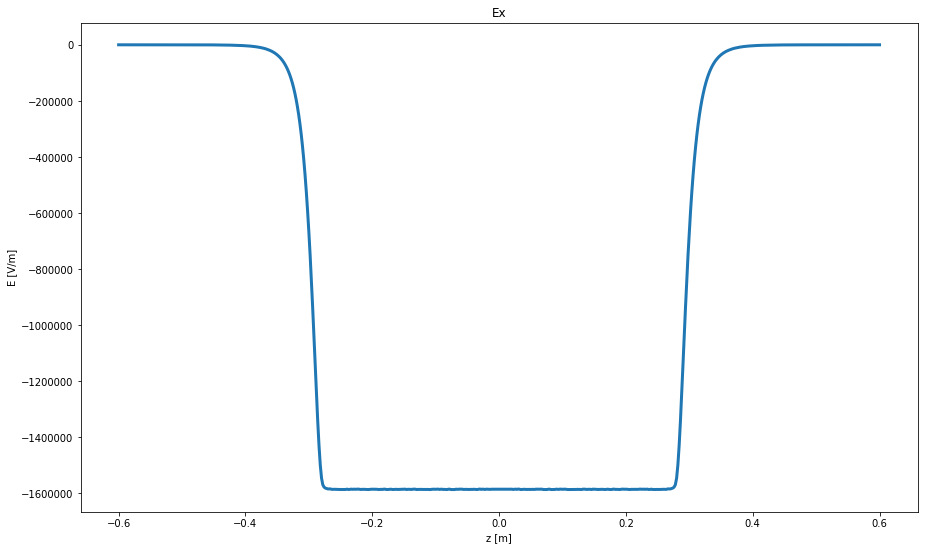

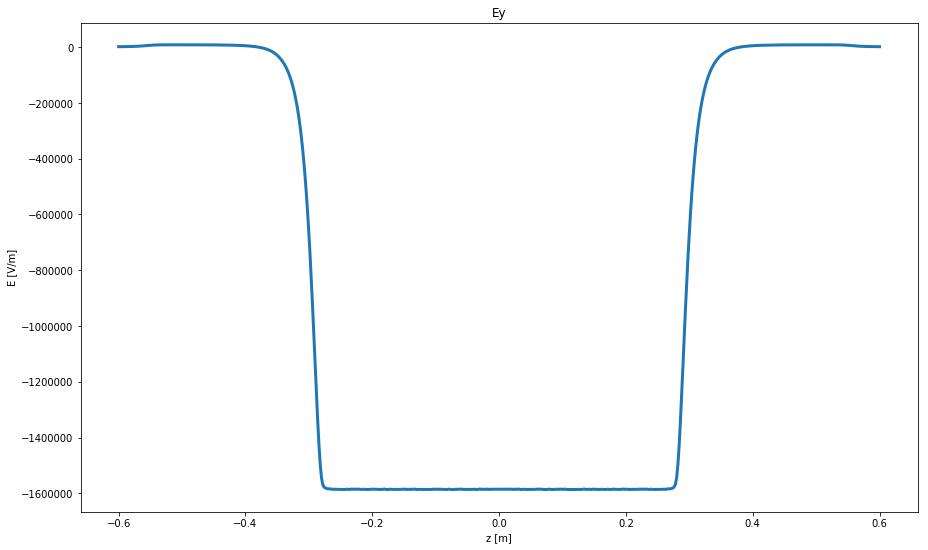

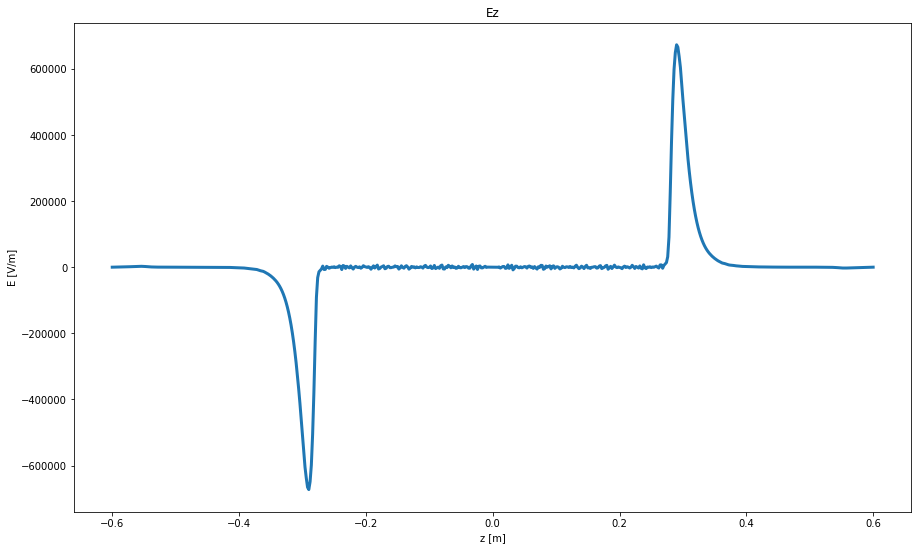

In [965]:
x_cder = polynomial.polyder(c, axis = 0)
x_cPder = polynomial.polyder(cP, axis = 0)
y_cder = polynomial.polyder(c, axis = 1)
y_cPder = polynomial.polyder(cP, axis = 1)

Ex_tot = lambda x,y,z: intfunP(z)*polynomial.polyval2d(x,y,x_cPder)+intfun(z)*polynomial.polyval2d(x,y,x_cder)
Ey_tot = lambda x,y,z: intfunP(z)*polynomial.polyval2d(x,y,y_cPder)+intfun(z)*polynomial.polyval2d(x,y,y_cder)
Ez_tot = lambda x,y,z: intfunP.derivative()(z)*polynomial.polyval2d(x,y,cP)+intfun.derivative()(z)*polynomial.polyval2d(x,y,c)
Etot = lambda x,y,z: np.sqrt(Ex_tot(x,y,z)**2+Ey_tot(x,y,z)**2+Ez_tot(x,y,z)**2)

idx = find_nearest(xP_vals, np.sqrt(0.019**2/2))
idy = find_nearest(yP_vals, np.sqrt(0.019**2/2))
xi = xP_vals[idx]
yi = yP_vals[idx]

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ex_tot(xi,yi,zP_spliced), lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/m]')
ax.set_title('Ex')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ey_tot(xi,yi,zP_spliced), lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/m]')
ax.set_title('Ey')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ez_tot(xi,yi,zP_spliced), lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/m]')
ax.set_title('Ez')

Text(0.5,1,'Ez')

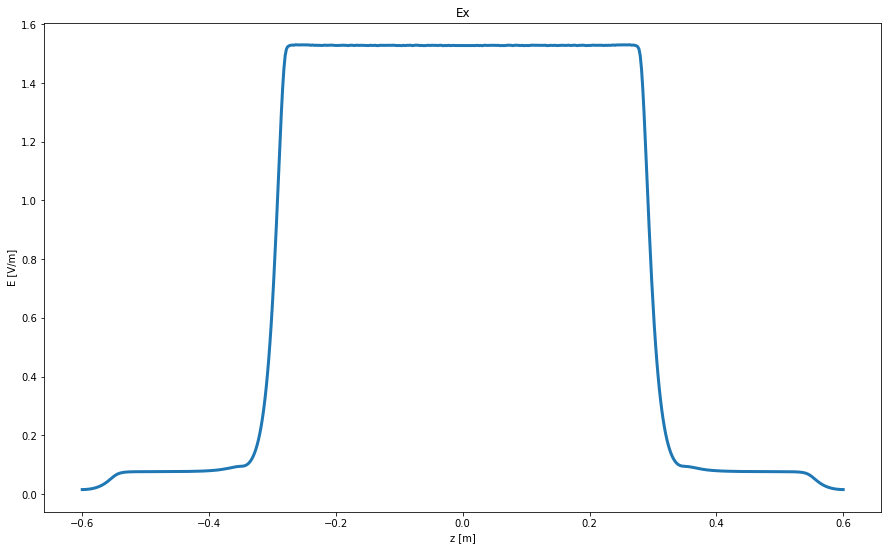

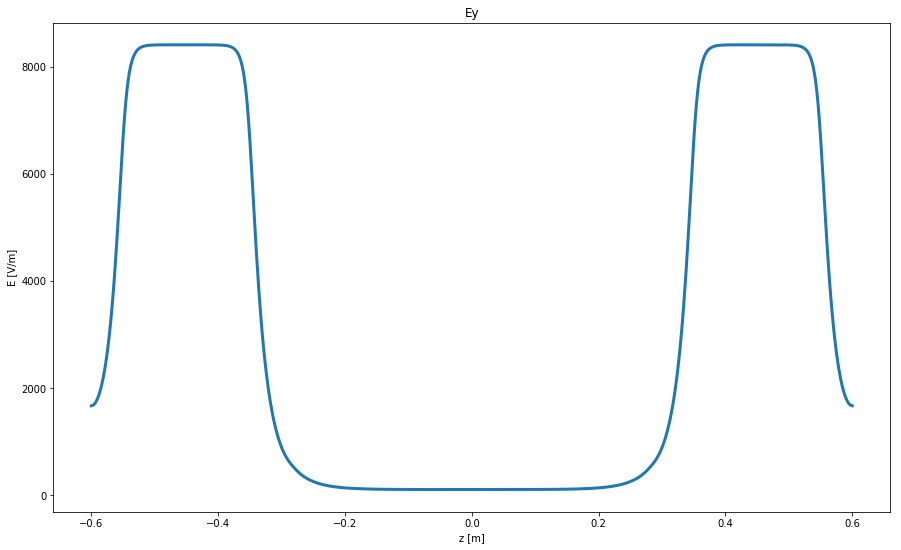

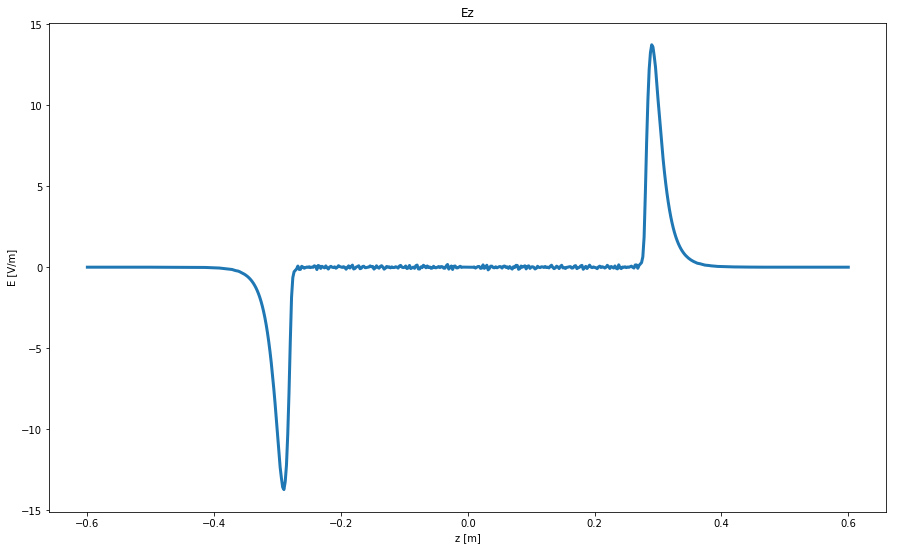

In [966]:
idx = find_nearest(xP_vals, np.sqrt(0**2/2))
idy = find_nearest(yP_vals, np.sqrt(0**2/2))
xi = xP_vals[idx]
yi = yP_vals[idx]

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ex_tot(xi,yi,zP_spliced), lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/m]')
ax.set_title('Ex')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ey_tot(xi,yi,zP_spliced), lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/m]')
ax.set_title('Ey')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ez_tot(xi,yi,zP_spliced), lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/m]')
ax.set_title('Ez')

Text(0.5,1,'|E|')

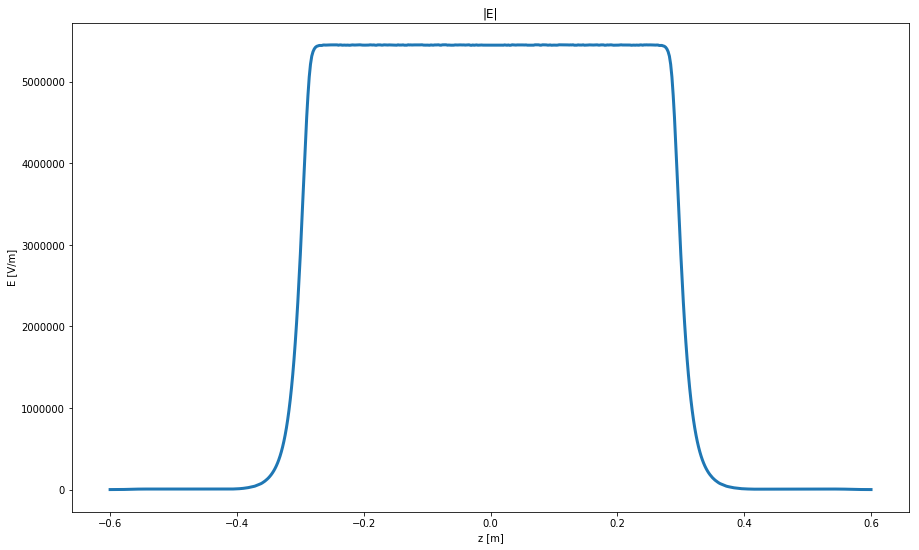

In [967]:
idx = find_nearest(xP_vals, np.sqrt(0.19**2/2))
idy = find_nearest(yP_vals, np.sqrt(0.19**2/2))
xi = xP_vals[idx]
yi = yP_vals[idx]

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Etot(xi,yi,zP_spliced), lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/m]')
ax.set_title('|E|')

In [968]:
with open('fieldInterpolated.dat', 'wb') as wfp:
    pickle.dump((Ex_tot,Ey_tot,Ez_tot),wfp)